In [127]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
import scikitplot as skplt
from sklearn.metrics import confusion_matrix

In [128]:
df = pd.read_csv('filtered_file_MyDataset_12_not_twice.csv')

In [129]:
df = df.drop(['login'], axis=1)

In [130]:
# Фильтруем строки с outflow = 0
zero_outflow = df[df['outflow'] == 0]

# Выбираем случайные 60% строк для удаления
rows_to_delete = zero_outflow.sample(frac=0.6, random_state=0).index

# Удаляем выбранные строки из оригинального DataFrame
df = df.drop(rows_to_delete)

In [131]:
df.duplicated(keep=False).sum()

1036

In [132]:
df.drop('outflow', axis=1).duplicated(keep=False).sum()

1036

In [133]:
df = df.drop_duplicates()
df.head()

,mounth,year,failCount,failPause,failMax,lifeTime,activeLife,calls,rejectedCalls,unansweredCalls,...,addItv,gender,payments,paymentType,paymentSum,serviceTask,lk,bigFailure,sms,outflow
2,3,2021,1,360,360,99732809,55036800,0,0,0,...,0,1,0,0,0,0,0,0,0,0
7,3,2021,7,32820,30060,151484448,152496000,0,0,0,...,0,0,2,6,800,0,1,0,2,0
8,3,2021,7,32820,30060,152087684,150076800,0,0,0,...,0,0,1,3,700,0,0,0,2,1
11,3,2021,1,28080,28080,146549163,136659459,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,3,2021,2,26160,26160,148004969,147312000,0,0,0,...,0,1,2,6,1300,0,2,1,2,0


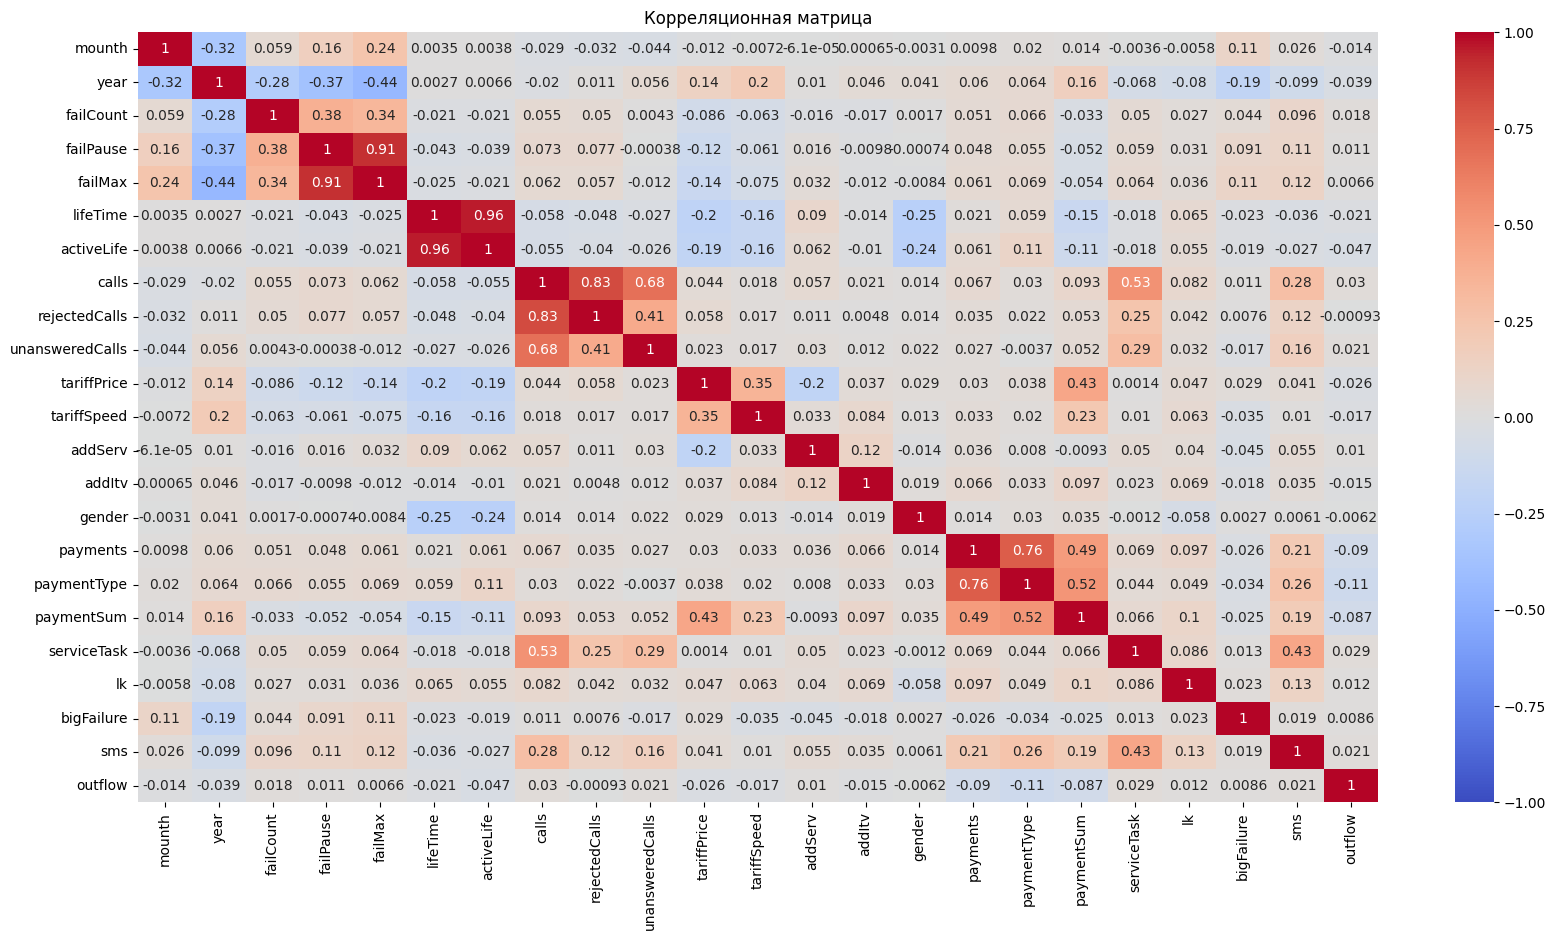

In [134]:
corr = df.corr()

# Построение тепловой карты
plt.figure(figsize=(20, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Корреляционная матрица')
plt.show()

In [135]:
df['day'] = 1

In [136]:
df = df.rename(columns={"mounth": "month"})
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day']])

In [137]:
df['activeTime/lifeTime'] = df['activeLife'] / df['lifeTime']

df['failCount/activeLife'] = df['failCount'] / df['activeLife']

df['rejectedCalls/calls'] = np.where(df['calls'] == 0, 0, df['rejectedCalls'] / df['calls'])

df['unansweredCalls/calls'] = np.where(df['calls'] == 0, 0, df['unansweredCalls'] / df['calls'])

In [138]:
def normalize(group, columns):
    for col in columns:
        X_min = group[col].min()
        X_max = group[col].max()
        # Защита от деления на ноль
        range_span = X_max - X_min
        if range_span == 0:
            group[f'{col}_n'] = 0
        else:
            group[f'{col}_n'] = (group[col] - X_min) / range_span
    return group

# Укажите колонки для нормализации
# columns_to_normalize = ['paymentSum', 'tariffPrice', 'tariffSpeed']
columns_to_normalize = ['lifeTime', 'activeLife', 'tariffPrice', 'tariffSpeed', 'paymentSum', 'activeTime/lifeTime', 'failCount/activeLife', 'rejectedCalls/calls', 'unansweredCalls/calls']


# Применяем нормализацию по месяцам
df = df.groupby('datetime', group_keys=False).apply(normalize, columns=columns_to_normalize)

In [139]:
seconds_per_day = 86400 
days_per_year = 365.25 

# Конвертация секунд в годы
df['lifeTime_years'] = df['lifeTime'] / seconds_per_day // days_per_year

In [140]:
df = df[~((df['year'] == 2022) & (df['month'] == 2))]

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, '0.0'),
  Text(1, 0, '1.0'),
  Text(2, 0, '2.0'),
  Text(3, 0, '3.0'),
  Text(4, 0, '4.0'),
  Text(5, 0, '5.0'),
  Text(6, 0, '6.0'),
  Text(7, 0, '7.0'),
  Text(8, 0, '8.0'),
  Text(9, 0, '9.0'),
  Text(10, 0, '10.0'),
  Text(11, 0, '11.0'),
  Text(12, 0, '12.0'),
  Text(13, 0, '13.0')])

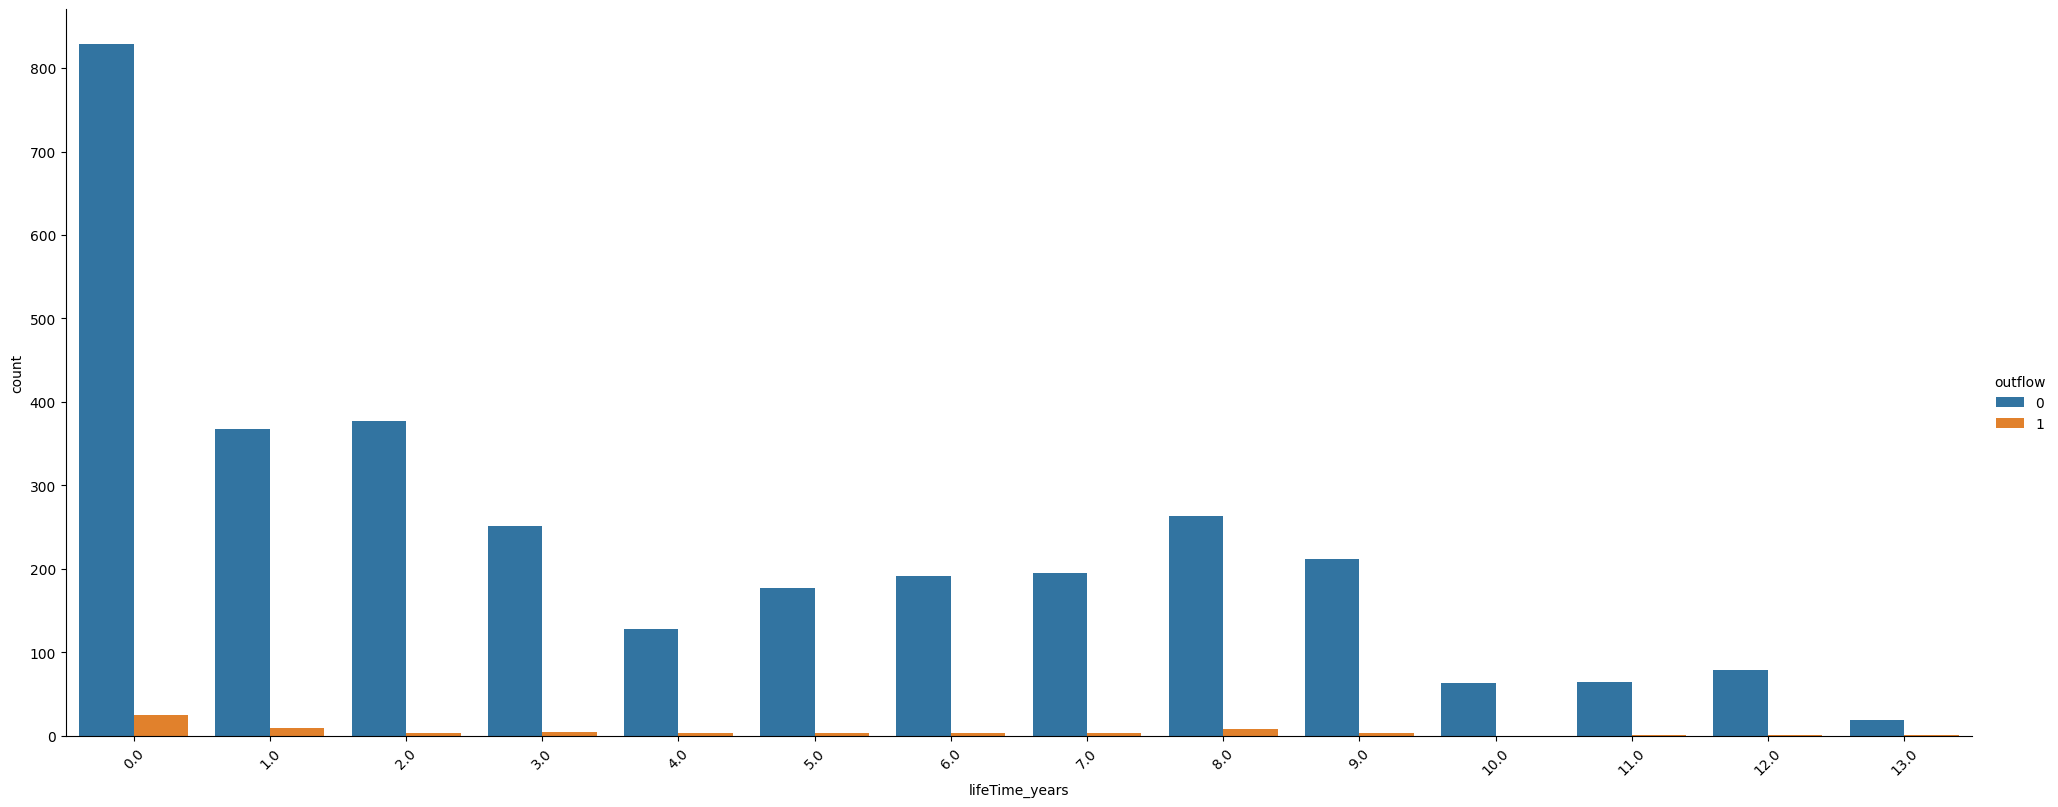

In [141]:
sns.catplot(data=df[df['year'] == 2024], x="lifeTime_years", hue="outflow", kind="count", height=8, aspect=20/8)
plt.xticks(rotation=45)

In [142]:
tmp = df.groupby("payments", as_index=False).agg({"outflow": ["sum", "count"]})
tmp["outflow (%)"] = 100 * tmp["outflow", "sum"] / tmp["outflow", "count"]
tmp.sort_values("outflow (%)").reset_index(drop=True)

payments outflow        outflow (%)
                sum  count            
0        14       0      1    0.000000
1        39       0      1    0.000000
2        38       0      1    0.000000
3        37       0      2    0.000000
4        33       0      2    0.000000
5        32       0      1    0.000000
6        29       0      1    0.000000
7        24       0      1    0.000000
8        22       0      1    0.000000
9        21       0      1    0.000000
10       18       0      2    0.000000
11       17       0      1    0.000000
12       15       0      1    0.000000
13       44       0      2    0.000000
14       13       0      1    0.000000
15       11       0      1    0.000000
16       10       0      4    0.000000
17        9       0      5    0.000000
18        8       0      6    0.000000
19        7       0     37    0.000000
20       43       0      1    0.000000
21        3     115  17730    0.648618
22        4      21   3049    0.688750
23        5       5    547    0.914077
24        6       2    161    1.242236
25        0      62   2964    2.091768
26        2     717  17141    4.182953
27        1     445   5245    8.484271

In [143]:
tmp = df.groupby("paymentType", as_index=False).agg({"outflow": ["sum", "count"]})
tmp["outflow (%)"] = 100 * tmp["outflow", "sum"] / tmp["outflow", "count"]
tmp.sort_values("outflow (%)").reset_index(drop=True)

paymentType outflow        outflow (%)
                   sum  count            
0            7       0     95    0.000000
1           11       0     95    0.000000
2           13       0      4    0.000000
3            9      31  17073    0.181573
4            0      62   2964    2.091768
5            4       5    226    2.212389
6            8       5    177    2.824859
7            6     726  19527    3.717929
8            5       8    142    5.633803
9            1       8    124    6.451613
10           2       8    100    8.000000
11           3     513   6376    8.045797
12          10       1      7   14.285714

In [144]:
tmp = df.groupby("bigFailure", as_index=False).agg({"outflow": ["sum", "count"]})
tmp["outflow (%)"] = 100 * tmp["outflow", "sum"] / tmp["outflow", "count"]
tmp.sort_values("outflow (%)").reset_index(drop=True)

bigFailure outflow        outflow (%)
                  sum  count            
0           8       0     32    0.000000
1          22       0      1    0.000000
2          24       0      1    0.000000
3          39       0      1    0.000000
4           5       1     79    1.265823
5          11       1     61    1.639344
6          10       2    101    1.980198
7           9       3    137    2.189781
8           7       5    193    2.590674
9           0    1214  42562    2.852310
10          1      68   2075    3.277108
11          2      37    957    3.866249
12          6       4     96    4.166667
13          4       8    167    4.790419
14          3      15    280    5.357143
15         30       9    167    5.389222

In [145]:
tmp = df.groupby("failCount", as_index=False).agg({"outflow": ["sum", "count"]})
tmp["outflow (%)"] = 100 * tmp["outflow", "sum"] / tmp["outflow", "count"]
tmp.sort_values("outflow (%)").reset_index(drop=True)

failCount outflow       outflow (%)
                  sum count            
0          53       0     2    0.000000
1          81       0     5    0.000000
2          80       0     1    0.000000
3          79       0     5    0.000000
4          74       0    16    0.000000
..        ...     ...   ...         ...
102       236       2     9   22.222222
103        63       3    13   23.076923
104       137       1     4   25.000000
105        44       1     4   25.000000
106       164       1     2   50.000000

[107 rows x 4 columns]

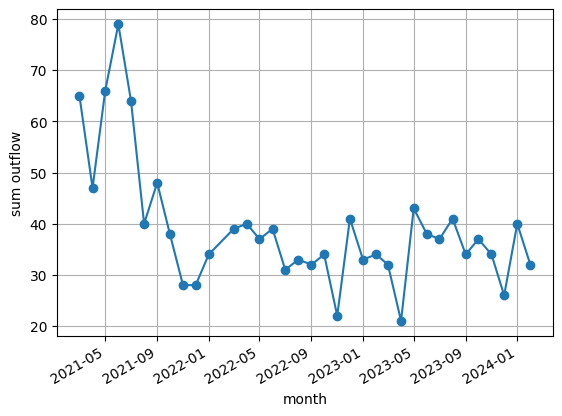

In [146]:
avg_price_per_year = df.groupby('datetime')['outflow'].sum()
avg_price_per_year.plot(kind='line', marker='o')
plt.xlabel('month')
plt.ylabel('sum outflow')
plt.grid(True)
plt.show()

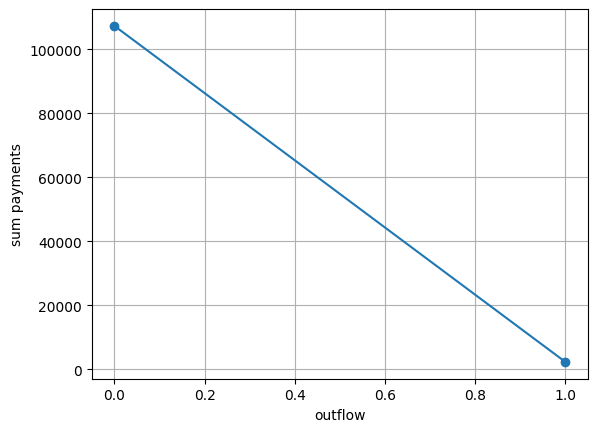

In [147]:
avg_price_per_year = df.groupby('outflow')['payments'].sum()
avg_price_per_year.plot(kind='line', marker='o')
plt.xlabel('outflow')
plt.ylabel('sum payments')
plt.grid(True)
plt.show()

In [178]:
df1 = df[df['year'] != 2024]
df2 = df[df['year'] == 2024]

In [179]:
df1 = df1.drop(['year', 'datetime', 'day'], axis=1)
df2 = df2.drop(['year', 'datetime', 'day'], axis=1)

In [150]:
# X = df.drop('outflow', axis=1).values
# y = df['outflow'].values


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)

In [180]:
X_train = df1.drop('outflow', axis=1)
X_test = df2.drop('outflow', axis=1)
y_train = df1['outflow']
y_test = df2['outflow']

In [181]:
train_data = Pool(X_train, y_train)
test_data = Pool(X_test, y_test)    

In [182]:
model = CatBoostClassifier(#class_weights=[1, 10],
                           auto_class_weights="SqrtBalanced",
                           learning_rate=0.01,
                           eval_metric='F1',
                        #    eval_metric="AUC:hints=skip_train~false",
                           iterations=5000,
                           l2_leaf_reg=10,
                           max_depth=2
                           ) 

model.fit(
    train_data, 
    eval_set=test_data)

0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 8.2ms	remaining: 41s
1:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 18.1ms	remaining: 45.2s
2:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 24.9ms	remaining: 41.5s
3:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 32.1ms	remaining: 40.1s
4:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 40.5ms	remaining: 40.5s
5:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 47.4ms	remaining: 39.4s
6:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 56.2ms	remaining: 40.1s
7:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 62.6ms	remaining: 39s
8:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 68.9ms	remaining: 38.2s
9:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 75.2ms	remaining: 37.5s
10:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 81.1ms	remaining: 36.8s
11:	learn: 0.0000000	test: 0.0000000	best: 0.00

Text(0.5, 1.0, 'Feature Importance')

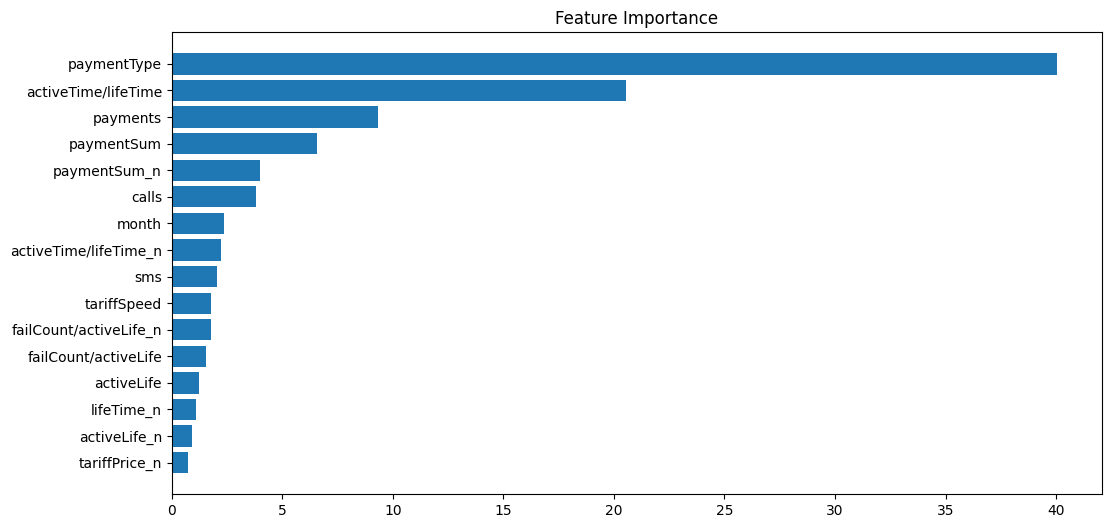

In [183]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_train.columns)[sorted_idx])
plt.title('Feature Importance')

In [177]:
threshold = 1

# Определяем индексы фичей, которые имеют важность ниже порога
low_importance_features = np.where(feature_importance < threshold)[0]

low_importance_feature_names = X_train.columns[low_importance_features]

df = df.drop(columns=low_importance_feature_names)


KeyError: "['failCount', 'failPause', 'failMax', 'lifeTime', 'rejectedCalls', 'unansweredCalls', 'tariffPrice', 'addServ', 'addItv', 'gender', 'serviceTask', 'lk', 'bigFailure', 'rejectedCalls/calls', 'unansweredCalls/calls', 'tariffSpeed_n', 'rejectedCalls/calls_n', 'unansweredCalls/calls_n', 'lifeTime_years'] not found in axis"

In [156]:
# Предсказание классов
predictions = model.predict(X_test)
print("Predicted classes:", predictions)

# Предсказание вероятностей
probabilities = model.predict_proba(X_test)
print("Predicted probabilities:", probabilities)

Predicted classes: [0 0 0 ... 0 0 0]
Predicted probabilities: [[0.80989207 0.19010793]
 [0.98770499 0.01229501]
 [0.98497463 0.01502537]
 ...
 [0.83087718 0.16912282]
 [0.77367892 0.22632108]
 [0.92037927 0.07962073]]


In [157]:
probabilities[:,1]

array([0.19010793, 0.01229501, 0.01502537, ..., 0.16912282, 0.22632108,
       0.07962073])

/home/leo/Documents/Projects/machine_learning_fridom/.venv/lib64/python3.11/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


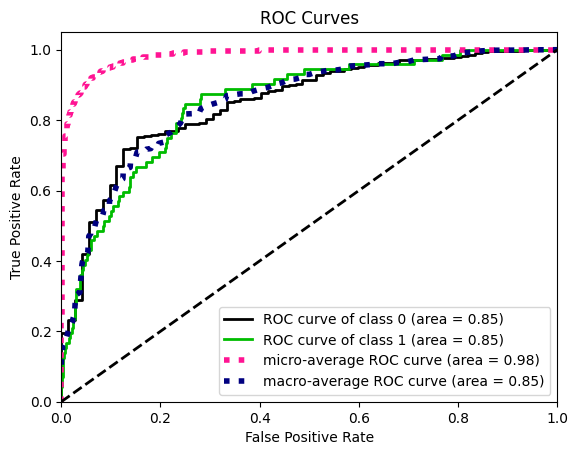

In [184]:
y_true = y_test
y_probas = probabilities
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()

In [186]:
# Задайте порог
threshold = 0.2

# Вероятности для класса 1
prob_class_1 = y_probas[:, 1]

# Прогнозы на основе порога
predictions = (prob_class_1 >= threshold).astype(int)

# Подсчитайте матрицу ошибок
tn, fp, fn, tp = confusion_matrix(y_true, predictions).ravel()

percent_true_positive = (tp / (tp + fn)) * 100
percent_false_positive = (fp / (fp + tn)) * 100

print('Всего 1:', sum(y_test))
print('Всего 0:', X_test['activeLife'].count())
print(f'Истинные положительные: {tp}')
print(f'Ложные положительные: {fp}')
print(f'Ложные отрицательные: {fn}')
print(f'Истинные отрицательные: {tn}')
print(f'Процент верно угаданных единиц: {percent_true_positive:.2f}%')
print(f'Процент нулей, предсказанных как единицы: {percent_false_positive:.2f}%')

Всего 1: 72
Всего 0: 3290
Истинные положительные: 61
Ложные положительные: 838
Ложные отрицательные: 11
Истинные отрицательные: 2380
Процент верно угаданных единиц: 84.72%
Процент нулей, предсказанных как единицы: 26.04%


In [189]:
# Задайте процент допустимых ошибок в нулях
percent_error_allowed = 5

# Вероятности для класса 1
prob_class_1 = y_probas[:, 1]

total_zeros = sum(y_true == 0)

# Определите количество допустимых ошибок
allowed_errors = int(total_zeros * percent_error_allowed / 100)

sorted_prob_class_1 = np.sort(prob_class_1[y_true == 0])
threshold_for_error = sorted_prob_class_1[-allowed_errors] if allowed_errors > 0 else 1.0

predictions = (prob_class_1 >= threshold_for_error).astype(int)

tn, fp, fn, tp = confusion_matrix(y_true, predictions).ravel()

percent_true_positive = (tp / (tp + fn)) * 100
percent_false_positive = (fp / (fp + tn)) * 100

print('Всего 1:', sum(y_true))
print('Всего 0:', total_zeros)
print(f'Истинные положительные: {tp}')
print(f'Ложные положительные: {fp}')
print(f'Ложные отрицательные: {fn}')
print(f'Истинные отрицательные: {tn}')
print(f'Процент верно угаданных единиц: {percent_true_positive:.2f}%')
print(f'Процент нулей, предсказанных как единицы: {percent_false_positive:.2f}%')
print(f'Выбранный порог для ошибки в нулях: {threshold_for_error:.2f}')


Всего 1: 72
Всего 0: 3218
Истинные положительные: 68
Ложные положительные: 1609
Ложные отрицательные: 4
Истинные отрицательные: 1609
Процент верно угаданных единиц: 94.44%
Процент нулей, предсказанных как единицы: 50.00%
Выбранный порог для ошибки в нулях: 0.08


In [160]:
X_test['activeLife'].count()

3290